In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
seed = 230
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  ZK75TX1R_16_36_57
NN-MODEL FILENAME:  ./models/ZK75TX1R_16_36_57_NN.pt


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [8]:
T_LR           = 1e-1
T_GAMMA        = 0.95
T_EPSILON      = 0.98

NO_OF_NODES    = 200
NO_OF_EPISODES = 20
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  200
Number of EPISODES per NODE 20


In [9]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [10]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 7000

In [11]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [13]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  4.5
P_VEL_ABS_MIN = -4.5

LENGTH_ABS_MAX = 0.8
LENGTH_ABS_MIN = 0.2

In [14]:
# SET GRANULARITY
LO_GRAIN = 15
HI_GRAIN = 30
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  30
LO_GRAIN =  15


In [15]:
def mp_node_run(node_id, boundary):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
    
    # Mean values of pole length deviate by 40% from original value
    scaling_factor = 0.5 + (1.5 - 0.5) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = boundary
    ###############################################
        
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_ABS_MIN, LENGTH_ABS_MAX, LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################

    
#     my_dqn = D3QN()
#     my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
#     my_dqn.eval_net.eval()
    my_QFILE   = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
    my_Q_TABLE = np.load(my_QFILE)
#     my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , LO_GRAIN , LO_GRAIN , -1)

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    my_EPSILON   = T_EPSILON
    my_LR        = T_LR

    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

                     
            my_env.length   = length_mean + np.random.uniform(-0.05,0.05)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - 
#                                                                          my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]
    
#     LENGTH_MAX = exp_rec[:,4].max() + 0.25*np.abs(exp_rec[:,4].max())
#     LENGTH_MIN = exp_rec[:,4].min() - 0.25*np.abs(exp_rec[:,4].min())

    # CLAMP STATE VALUE BORDERS
    ###############################################
#     C_POS_MAX = clamp(C_POS_ABS_MIN, C_POS_MAX, C_POS_ABS_MAX)
#     C_POS_MIN = clamp(C_POS_ABS_MIN, C_POS_MIN, C_POS_ABS_MAX) 

#     C_VEL_MAX = clamp(C_VEL_ABS_MIN, C_VEL_MAX, C_VEL_ABS_MAX)
#     C_VEL_MIN = clamp(C_VEL_ABS_MIN, C_VEL_MIN, C_VEL_ABS_MAX) 

#     P_ANG_MAX = clamp(P_ANG_ABS_MIN, P_ANG_MAX, P_ANG_ABS_MAX)
#     P_ANG_MIN = clamp(P_ANG_ABS_MIN, P_ANG_MIN, P_ANG_ABS_MAX) 

#     P_VEL_MAX = clamp(P_VEL_ABS_MIN, P_VEL_MAX, P_VEL_ABS_MAX)
#     P_VEL_MIN = clamp(P_VEL_ABS_MIN, P_VEL_MIN, P_VEL_ABS_MAX) 

#     LENGTH_MAX = clamp(LENGTH_ABS_MIN, LENGTH_MAX + 0.1, LENGTH_ABS_MAX)
#     LENGTH_MIN = clamp(LENGTH_ABS_MIN, LENGTH_MIN - 0.1, LENGTH_ABS_MAX)
    ###############################################

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [16]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [17]:
iteration = 0
dqn = D3QN()
# INITIALIZE MODEL FILE
torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

In [18]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# INITIALIZE QFILES FOR EACH NODE
#############################################################################################################################################
# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]

 # SET STATE VALUE BORDERS
###############################################
[C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
 C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = init_node_boundary
###############################################

# CREATE STATE COMBINATIONS
###############################################

init_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
                                    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
###############################################

# GET Q-VALUES 
start = timeit.default_timer()
% memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# for node_id in range(NO_OF_NODES):
node_QFILE = './Q_NPY/' + RNDM_STRING +  'QFILE' + ".npy"
np.save(node_QFILE, init_q_table)
#############################################################################################################################################

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES

peak memory: 5613.85 MiB, increment: 5006.98 MiB
Quantization TIME:  0.05 minutes




ITERATION # 0
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 0: 117
REAL TIME TO GENERATE 62450 EXPERIENCES:0:00:01.798187


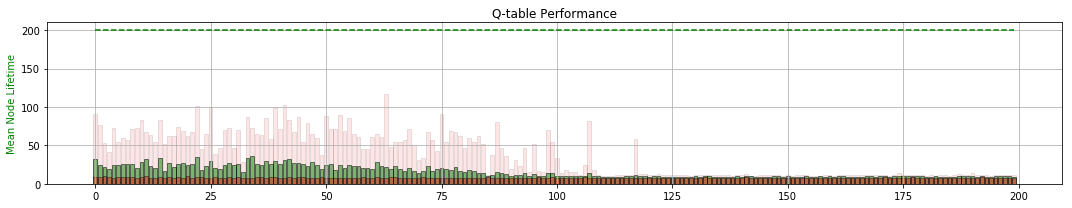

GOOD MEMORY COUNTER:  58450
BAD MEMORY COUNTER:  4000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  108.845
Validating... MEAN TIME:  168.11
Validating... MEAN TIME:  198.585
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  189.745
TRAINING TIME:0:00:44.575040


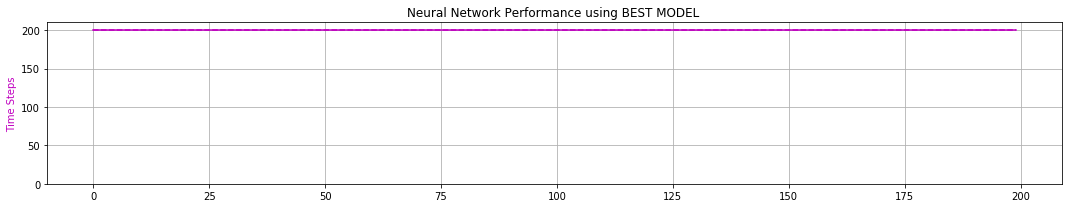

0 -max- [ 0.355  1.737  0.201  0.794  0.301]
0 -min- [-0.043 -0.145 -0.208 -2.762  0.205]

1 -max- [ 0.214  1.564  0.197  0.796  0.303]
1 -min- [-0.050 -0.177 -0.206 -2.506  0.207]

2 -max- [ 0.187  1.736  0.038  0.129  0.301]
2 -min- [-0.049 -0.048 -0.207 -2.754  0.215]

3 -max- [ 0.164  1.732  0.206  0.771  0.308]
3 -min- [-0.048 -0.212 -0.209 -2.705  0.211]

4 -max- [ 0.211  1.713  0.206  0.875  0.312]
4 -min- [-0.043 -0.233 -0.201 -2.696  0.214]

5 -max- [ 0.199  1.734  0.202  0.745  0.308]
5 -min- [-0.050 -0.191 -0.208 -2.724  0.221]

6 -max- [ 0.159  1.544  0.205  0.778  0.309]
6 -min- [-0.049 -0.196 -0.209 -2.507  0.223]

7 -max- [ 0.188  1.580  0.047  0.269  0.319]
7 -min- [-0.040 -0.202 -0.208 -2.478  0.233]

8 -max- [ 0.191  1.730  0.205  0.773  0.320]
8 -min- [-0.042 -0.201 -0.209 -2.765  0.223]

9 -max- [ 0.191  1.725  0.207  0.965  0.320]
9 -min- [-0.050 -0.046 -0.205 -2.765  0.229]

10 -max- [ 0.199  1.774  0.208  0.795  0.325]
10 -min- [-0.050 -0.165 -0.205 -2.670  0.234

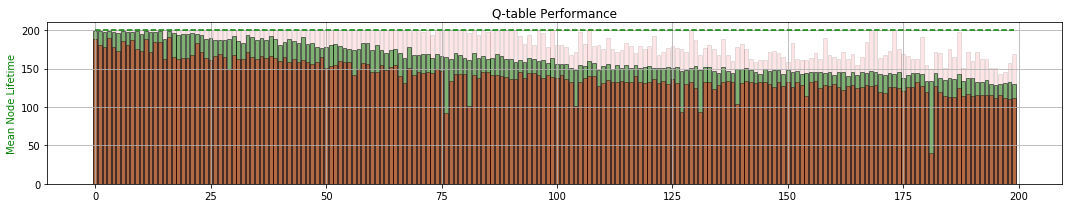

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  7366
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  130.575
Validating... MEAN TIME:  195.865
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.96
TRAINING TIME:0:00:46.381398


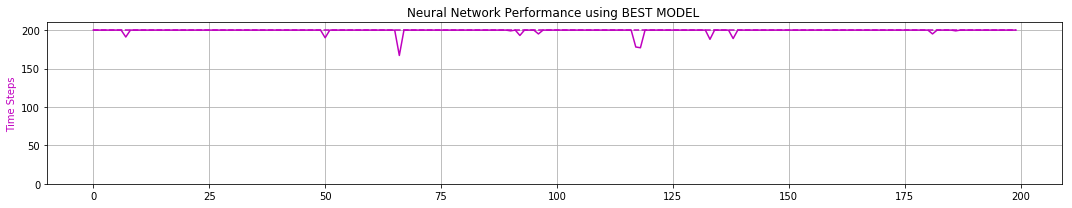

0 -max- [ 0.127  0.749  0.168  0.803  0.300]
0 -min- [-2.396 -1.469 -0.145 -1.002  0.205]

1 -max- [ 0.097  0.586  0.190  0.941  0.302]
1 -min- [-2.400 -1.671 -0.154 -1.242  0.207]

2 -max- [ 0.128  0.430  0.124  1.182  0.307]
2 -min- [-2.398 -1.725 -0.139 -1.027  0.218]

3 -max- [ 0.132  0.429  0.108  0.751  0.309]
3 -min- [-2.389 -1.536 -0.131 -1.028  0.212]

4 -max- [ 0.122  0.413  0.114  0.974  0.310]
4 -min- [-2.395 -1.623 -0.135 -1.023  0.216]

5 -max- [ 0.181  0.445  0.107  0.809  0.314]
5 -min- [-2.399 -1.532 -0.148 -1.035  0.216]

6 -max- [ 0.124  0.425  0.110  0.760  0.317]
6 -min- [-2.398 -1.507 -0.154 -1.029  0.222]

7 -max- [ 0.130  0.554  0.150  1.009  0.319]
7 -min- [-2.399 -1.524 -0.145 -1.216  0.223]

8 -max- [ 0.183  0.445  0.179  0.971  0.320]
8 -min- [-2.397 -1.529 -0.148 -1.277  0.227]

9 -max- [ 0.175  0.597  0.139  0.883  0.321]
9 -min- [-2.384 -1.529 -0.133 -1.031  0.232]

10 -max- [ 0.140  0.437  0.141  0.969  0.321]
10 -min- [-2.394 -1.664 -0.174 -1.319  0.242

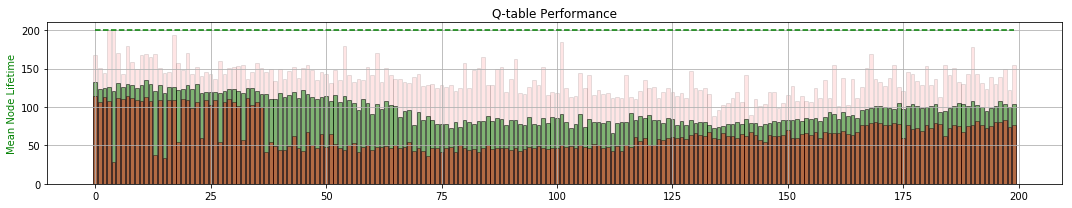

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  11364
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  197.66
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  164.17
Validating... MEAN TIME:  126.32
TRAINING TIME:0:00:44.473718


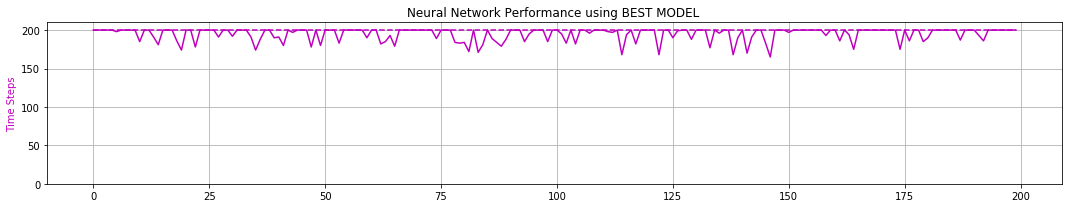

0 -max- [ 0.127  0.439  0.172  1.012  0.297]
0 -min- [-2.391 -2.435 -0.209 -1.615  0.206]

1 -max- [ 0.094  0.431  0.168  0.816  0.302]
1 -min- [-2.395 -2.401 -0.208 -1.534  0.207]

2 -max- [ 0.106  0.397  0.164  1.055  0.303]
2 -min- [-2.395 -2.459 -0.209 -1.482  0.214]

3 -max- [ 0.137  0.410  0.156  1.024  0.298]
3 -min- [-2.398 -2.435 -0.209 -1.449  0.219]

4 -max- [ 0.187  0.461  0.184  0.791  0.311]
4 -min- [-2.400 -2.254 -0.208 -1.574  0.216]

5 -max- [ 0.167  0.419  0.147  0.894  0.308]
5 -min- [-2.398 -2.428 -0.209 -1.820  0.223]

6 -max- [ 0.098  0.434  0.148  1.057  0.311]
6 -min- [-2.393 -2.593 -0.209 -1.542  0.218]

7 -max- [ 0.088  0.439  0.174  1.075  0.319]
7 -min- [-2.394 -2.374 -0.208 -1.476  0.220]

8 -max- [ 0.188  0.585  0.155  0.965  0.322]
8 -min- [-2.400 -2.384 -0.208 -1.489  0.229]

9 -max- [ 0.136  0.427  0.146  1.058  0.315]
9 -min- [-2.390 -2.638 -0.209 -1.643  0.228]

10 -max- [ 0.158  0.423  0.154  0.958  0.320]
10 -min- [-2.399 -2.428 -0.209 -1.602  0.233

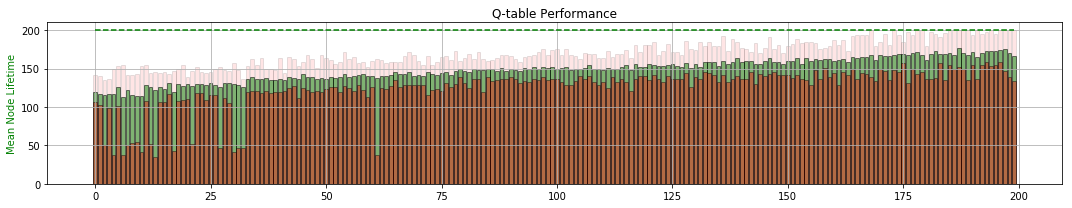

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  15348
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  189.64
Validating... MEAN TIME:  147.57
Validating... MEAN TIME:  147.5
Validating... MEAN TIME:  138.175
Validating... MEAN TIME:  130.715
TRAINING TIME:0:00:40.698985


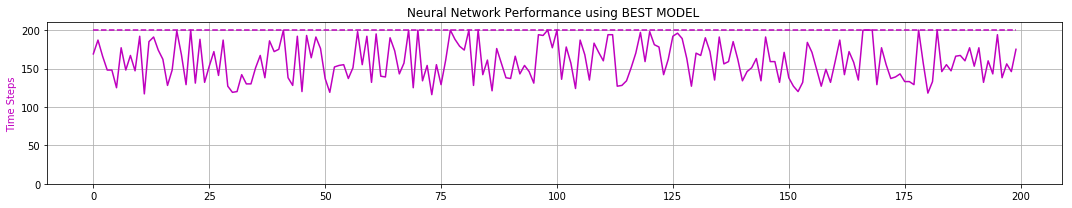

0 -max- [ 0.113  0.439  0.055  0.710  0.298]
0 -min- [-2.400 -2.583 -0.209 -1.045  0.205]

1 -max- [ 0.089  0.430  0.077  0.728  0.299]
1 -min- [-2.400 -2.728 -0.209 -1.221  0.211]

2 -max- [ 0.105  0.430  0.063  0.726  0.301]
2 -min- [-2.393 -2.584 -0.209 -1.077  0.214]

3 -max- [ 0.103  0.596  0.055  0.818  0.307]
3 -min- [-2.400 -2.760 -0.202 -1.019  0.220]

4 -max- [ 0.117  0.439  0.066  0.753  0.305]
4 -min- [-2.397 -2.543 -0.209 -1.091  0.213]

5 -max- [ 0.148  0.598  0.067  0.735  0.310]
5 -min- [-2.399 -2.767 -0.202 -1.244  0.229]

6 -max- [ 0.095  0.537  0.063  0.777  0.312]
6 -min- [-2.396 -2.584 -0.206 -1.050  0.222]

7 -max- [ 0.092  0.440  0.059  0.894  0.319]
7 -min- [-2.399 -2.566 -0.207 -1.305  0.223]

8 -max- [ 0.146  0.584  0.057  0.998  0.314]
8 -min- [-2.398 -2.606 -0.208 -0.982  0.223]

9 -max- [ 0.129  0.427  0.060  0.912  0.325]
9 -min- [-2.399 -2.542 -0.209 -1.359  0.227]

10 -max- [ 0.118  0.617  0.068  0.729  0.325]
10 -min- [-2.400 -2.720 -0.206 -1.368  0.238

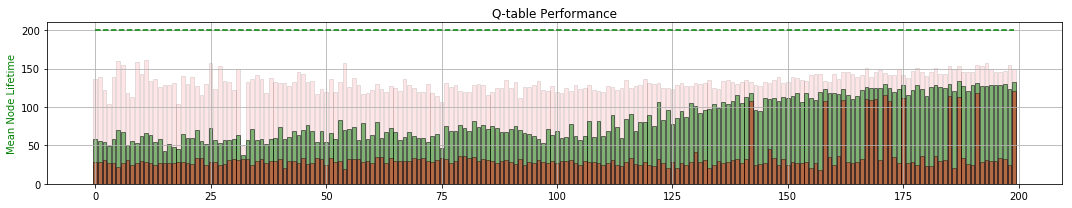

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  19348
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  179.965
Validating... MEAN TIME:  188.61
Validating... MEAN TIME:  187.3
Validating... MEAN TIME:  169.02
Validating... MEAN TIME:  146.75
TRAINING TIME:0:00:45.621221


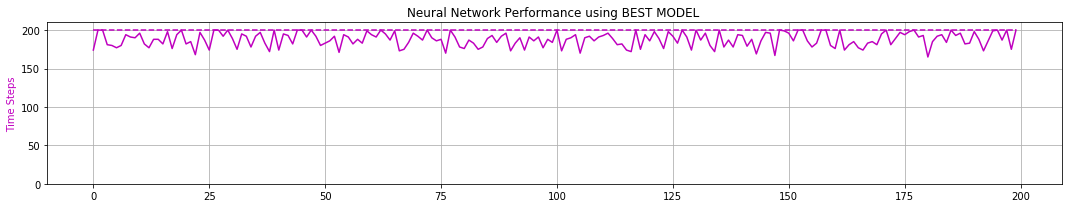

0 -max- [ 0.127  0.563  0.050  0.731  0.295]
0 -min- [-2.396 -2.388 -0.209 -0.802  0.206]

1 -max- [ 0.097  0.406  0.048  0.707  0.301]
1 -min- [-2.392 -2.390 -0.209 -0.770  0.209]

2 -max- [ 0.147  0.411  0.038  0.704  0.306]
2 -min- [-2.389 -2.375 -0.209 -0.903  0.209]

3 -max- [ 0.147  0.556  0.048  0.689  0.308]
3 -min- [-2.394 -2.363 -0.209 -0.901  0.213]

4 -max- [ 0.130  0.582  0.045  0.737  0.307]
4 -min- [-2.400 -2.376 -0.209 -0.990  0.213]

5 -max- [ 0.196  0.553  0.049  0.939  0.308]
5 -min- [-2.376 -2.559 -0.209 -1.097  0.220]

6 -max- [ 0.125  0.425  0.048  0.705  0.311]
6 -min- [-2.399 -2.387 -0.209 -0.768  0.223]

7 -max- [ 0.128  0.563  0.047  0.664  0.319]
7 -min- [-2.378 -2.188 -0.209 -0.813  0.234]

8 -max- [ 0.193  0.432  0.050  0.710  0.320]
8 -min- [-2.395 -2.367 -0.209 -0.763  0.224]

9 -max- [ 0.181  0.427  0.049  0.737  0.319]
9 -min- [-2.399 -2.359 -0.209 -0.773  0.233]

10 -max- [ 0.140  0.438  0.046  0.712  0.326]
10 -min- [-2.379 -2.374 -0.209 -0.802  0.228

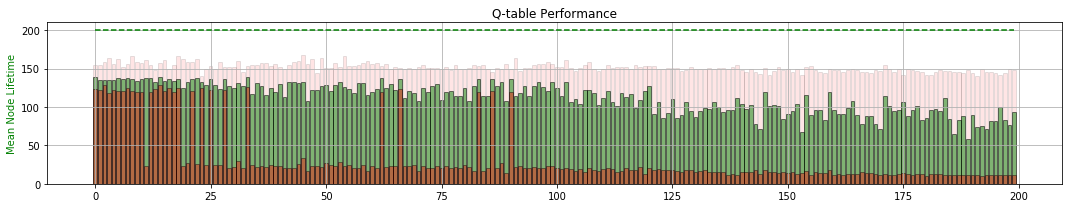

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  23348
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  150.595
Validating... MEAN TIME:  136.785
Validating... MEAN TIME:  141.25
Validating... MEAN TIME:  149.13
Validating... MEAN TIME:  147.67
TRAINING TIME:0:00:38.922412


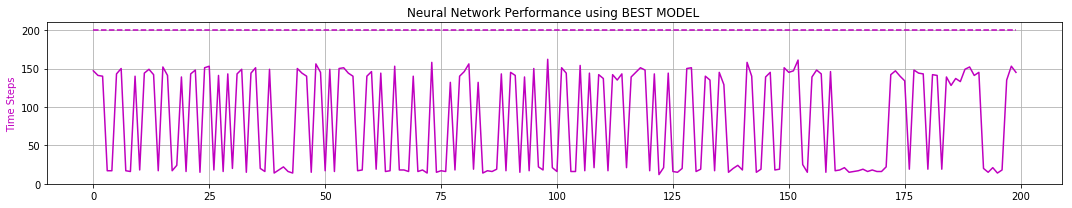

0 -max- [ 0.131  0.603  0.108  0.970  0.302]
0 -min- [-2.396 -1.969 -0.196 -1.067  0.215]

1 -max- [ 0.117  0.609  0.079  0.995  0.300]
1 -min- [-2.400 -2.176 -0.201 -1.086  0.209]

2 -max- [ 0.123  0.636  0.076  1.112  0.293]
2 -min- [-2.400 -2.057 -0.195 -0.939  0.209]

3 -max- [ 0.126  0.565  0.081  0.970  0.309]
3 -min- [-2.399 -2.091 -0.194 -0.875  0.211]

4 -max- [ 0.144  0.637  0.093  1.012  0.312]
4 -min- [-2.400 -2.251 -0.197 -0.931  0.216]

5 -max- [ 0.174  0.443  0.080  0.975  0.311]
5 -min- [-2.400 -2.238 -0.197 -1.020  0.216]

6 -max- [ 0.126  0.445  0.082  1.015  0.312]
6 -min- [-2.397 -2.016 -0.197 -0.971  0.225]

7 -max- [ 0.116  0.631  0.091  1.019  0.319]
7 -min- [-2.397 -1.996 -0.203 -1.037  0.231]

8 -max- [ 0.164  0.619  0.091  0.981  0.322]
8 -min- [-2.397 -2.092 -0.195 -0.994  0.224]

9 -max- [ 0.151  0.438  0.094  1.013  0.321]
9 -min- [-2.398 -2.078 -0.193 -0.839  0.225]

10 -max- [ 0.144  0.438  0.088  0.980  0.320]
10 -min- [-2.398 -2.091 -0.195 -1.080  0.233

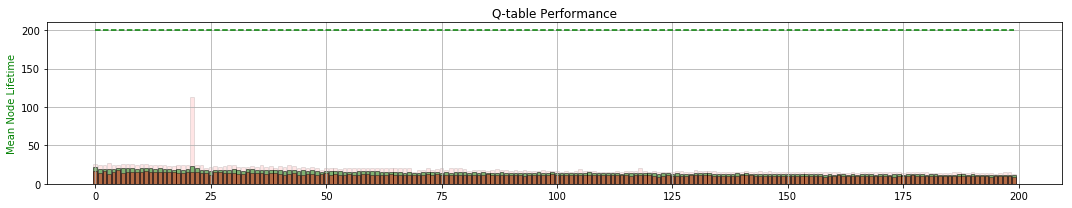

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  27348
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  15.0
Validating... MEAN TIME:  9.325
Validating... MEAN TIME:  9.4
Validating... MEAN TIME:  10.125
Validating... MEAN TIME:  19.395
TRAINING TIME:0:00:12.731778


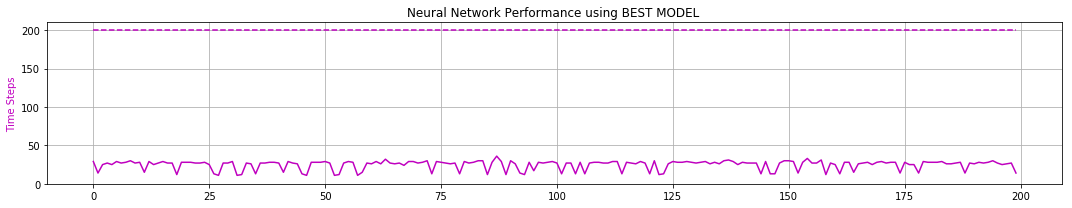

0 -max- [ 0.161  0.754  0.050  0.038  0.297]
0 -min- [-0.043 -0.387 -0.209 -1.104  0.203]

1 -max- [ 0.142  0.635  0.048  0.048  0.302]
1 -min- [-0.050 -0.373 -0.209 -1.082  0.207]

2 -max- [ 0.163  0.750  0.038  0.049  0.302]
2 -min- [-0.049 -0.407 -0.209 -1.212  0.215]

3 -max- [ 0.151  0.778  0.048  0.044  0.308]
3 -min- [-0.048 -0.411 -0.209 -1.283  0.213]

4 -max- [ 0.173  0.636  0.045  0.039  0.306]
4 -min- [-0.043 -0.397 -0.209 -1.004  0.213]

5 -max- [ 0.202  0.792  0.048  0.046  0.311]
5 -min- [-0.050 -0.411 -0.209 -1.239  0.220]

6 -max- [ 0.147  0.792  0.048  0.257  0.317]
6 -min- [-0.049 -0.412 -0.209 -1.104  0.225]

7 -max- [ 0.147  0.635  0.047  0.271  0.319]
7 -min- [-0.040 -0.372 -0.209 -0.990  0.232]

8 -max- [ 0.182  0.780  0.050  0.048  0.322]
8 -min- [-0.042 -0.405 -0.209 -1.069  0.229]

9 -max- [ 0.181  0.746  0.049  0.048  0.322]
9 -min- [-0.050 -0.410 -0.209 -1.168  0.227]

10 -max- [ 0.174  0.796  0.043  0.049  0.326]
10 -min- [-0.050 -0.412 -0.209 -1.129  0.229

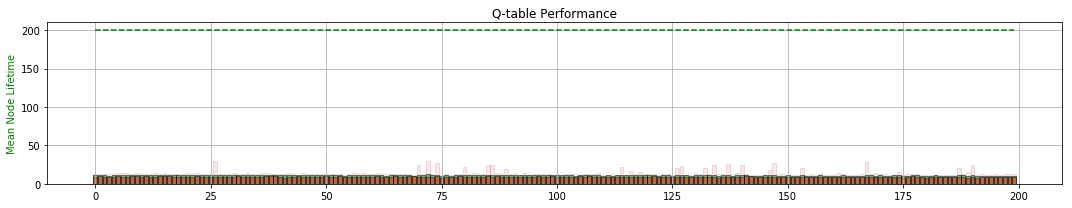

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  31348
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.43
Validating... MEAN TIME:  9.355
Validating... MEAN TIME:  31.695
Validating... MEAN TIME:  157.4
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:27.030528


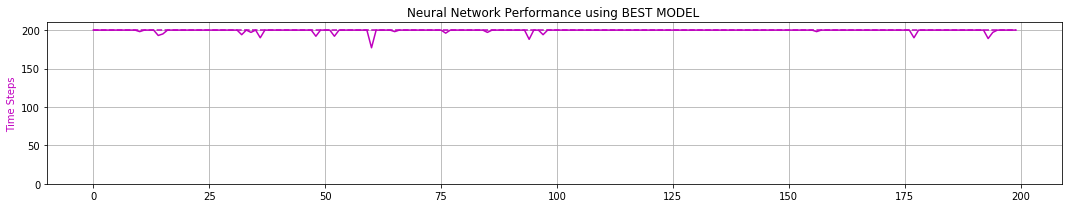

0 -max- [ 0.182  1.219  0.050  0.038  0.298]
0 -min- [-0.043 -0.043 -0.206 -1.864  0.205]

1 -max- [ 0.168  1.343  0.048  0.048  0.297]
1 -min- [-0.050 -0.050 -0.209 -1.988  0.213]

2 -max- [ 0.179  1.178  0.038  0.049  0.300]
2 -min- [-0.049 -0.048 -0.209 -1.890  0.209]

3 -max- [ 0.168  1.342  0.209  1.423  0.308]
3 -min- [-0.094 -0.777 -0.205 -2.036  0.212]

4 -max- [ 0.199  1.193  0.045  0.039  0.311]
4 -min- [-0.043 -0.045 -0.209 -1.749  0.213]

5 -max- [ 0.217  1.377  0.048  0.046  0.314]
5 -min- [-0.050 -0.045 -0.209 -1.994  0.215]

6 -max- [ 0.177  1.191  0.048  0.049  0.312]
6 -min- [-0.049 -0.049 -0.208 -1.771  0.218]

7 -max- [ 0.165  1.339  0.185  1.389  0.319]
7 -min- [-0.080 -0.801 -0.209 -1.981  0.228]

8 -max- [ 0.205  1.213  0.050  0.048  0.322]
8 -min- [-0.042 -0.050 -0.207 -1.765  0.223]

9 -max- [ 0.203  1.197  0.049  0.048  0.325]
9 -min- [-0.050 -0.046 -0.209 -1.792  0.232]

10 -max- [ 0.186  1.203  0.043  0.049  0.322]
10 -min- [-0.050 -0.049 -0.208 -1.824  0.235

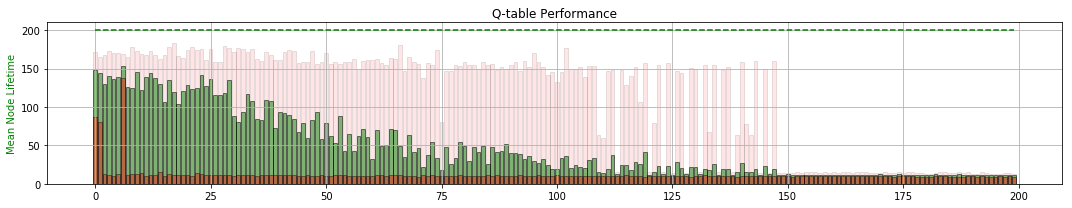

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  35348
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  190.59
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  195.24
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:50.357109


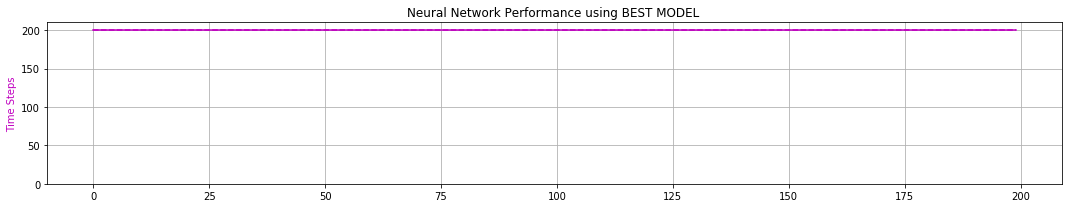

0 -max- [ 0.163  1.144  0.092  1.015  0.301]
0 -min- [-2.398 -2.416 -0.209 -1.689  0.205]

1 -max- [ 0.141  0.825  0.092  1.022  0.298]
1 -min- [-2.400 -2.430 -0.209 -1.366  0.223]

2 -max- [ 0.179  1.178  0.093  1.023  0.302]
2 -min- [-2.396 -2.426 -0.209 -1.703  0.213]

3 -max- [ 0.168  1.376  0.089  1.037  0.310]
3 -min- [-2.389 -2.412 -0.208 -1.965  0.219]

4 -max- [ 0.173  0.832  0.089  1.141  0.307]
4 -min- [-2.400 -2.415 -0.209 -1.518  0.216]

5 -max- [ 0.203  1.182  0.088  1.355  0.308]
5 -min- [-2.397 -2.423 -0.209 -1.690  0.217]

6 -max- [ 0.152  0.832  0.088  1.064  0.307]
6 -min- [-2.398 -2.408 -0.209 -1.372  0.225]

7 -max- [ 0.152  1.144  0.090  1.020  0.319]
7 -min- [-2.395 -2.354 -0.207 -1.709  0.227]

8 -max- [ 0.205  1.365  0.084  1.021  0.321]
8 -min- [-2.395 -2.433 -0.209 -1.951  0.227]

9 -max- [ 0.177  1.001  0.090  0.995  0.315]
9 -min- [-2.398 -2.421 -0.206 -1.527  0.225]

10 -max- [ 0.176  1.187  0.116  1.030  0.325]
10 -min- [-2.398 -2.625 -0.209 -1.632  0.242

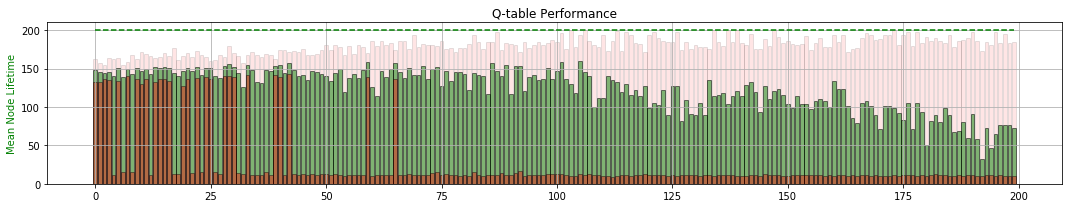

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  39341
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  196.12
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  196.535
TRAINING TIME:0:00:50.671299


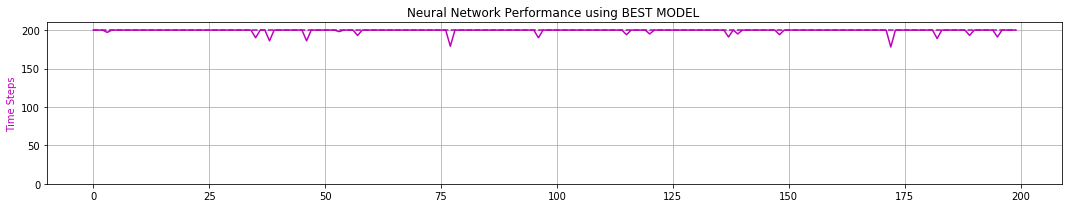

0 -max- [ 0.163  0.831  0.065  1.192  0.299]
0 -min- [-2.396 -2.172 -0.207 -1.277  0.205]

1 -max- [ 0.141  0.823  0.049  1.183  0.304]
1 -min- [-2.399 -2.216 -0.197 -1.299  0.208]

2 -max- [ 0.169  1.177  0.038  1.178  0.303]
2 -min- [-2.400 -2.066 -0.202 -1.667  0.208]

3 -max- [ 0.154  1.180  0.058  1.212  0.307]
3 -min- [-2.400 -2.063 -0.188 -1.662  0.212]

4 -max- [ 0.158  0.992  0.064  1.153  0.311]
4 -min- [-2.399 -2.186 -0.203 -1.556  0.213]

5 -max- [ 0.192  0.831  0.063  1.454  0.309]
5 -min- [-2.400 -2.248 -0.201 -1.315  0.217]

6 -max- [ 0.152  0.830  0.050  1.131  0.317]
6 -min- [-2.400 -2.059 -0.204 -1.336  0.220]

7 -max- [ 0.139  0.831  0.063  1.256  0.319]
7 -min- [-2.399 -2.168 -0.191 -1.311  0.224]

8 -max- [ 0.175  1.190  0.054  1.256  0.322]
8 -min- [-2.400 -2.069 -0.202 -1.662  0.227]

9 -max- [ 0.177  0.823  0.049  1.467  0.319]
9 -min- [-2.400 -2.065 -0.181 -1.342  0.228]

10 -max- [ 0.161  1.189  0.043  1.228  0.318]
10 -min- [-2.397 -2.175 -0.195 -1.672  0.228

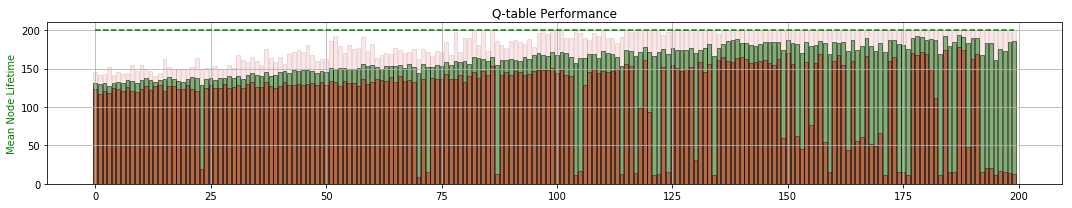

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  42964
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.985
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.97
TRAINING TIME:0:00:50.417797


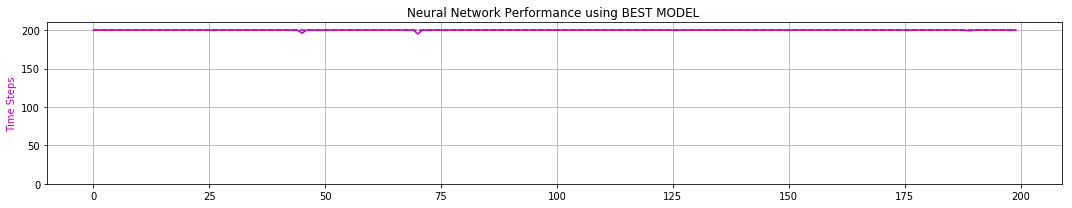

0 -max- [ 0.144  0.829  0.050  0.697  0.298]
0 -min- [-2.394 -2.219 -0.162 -1.219  0.204]

1 -max- [ 0.124  0.803  0.048  0.868  0.289]
1 -min- [-2.400 -2.443 -0.168 -1.213  0.210]

2 -max- [ 0.142  0.981  0.038  0.992  0.306]
2 -min- [-2.399 -2.247 -0.163 -1.370  0.208]

3 -max- [ 0.135  0.983  0.056  0.746  0.296]
3 -min- [-2.397 -2.222 -0.171 -1.328  0.218]

4 -max- [ 0.158  0.930  0.045  0.969  0.311]
4 -min- [-2.396 -2.237 -0.168 -1.426  0.216]

5 -max- [ 0.176  0.828  0.048  0.956  0.312]
5 -min- [-2.399 -2.256 -0.165 -1.215  0.219]

6 -max- [ 0.136  0.822  0.048  0.836  0.316]
6 -min- [-2.399 -2.241 -0.163 -1.211  0.220]

7 -max- [ 0.116  0.830  0.047  0.722  0.319]
7 -min- [-2.393 -2.239 -0.163 -1.214  0.239]

8 -max- [ 0.156  0.995  0.050  0.758  0.322]
8 -min- [-2.398 -2.437 -0.180 -1.366  0.223]

9 -max- [ 0.170  0.816  0.049  0.935  0.324]
9 -min- [-2.395 -2.253 -0.167 -1.220  0.227]

10 -max- [ 0.150  0.994  0.043  0.712  0.322]
10 -min- [-2.398 -2.363 -0.172 -1.374  0.238

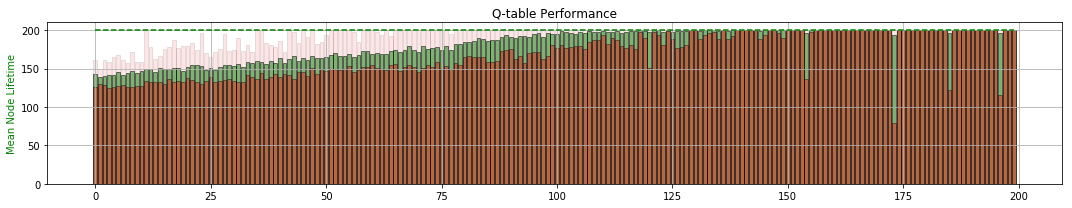

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  44908
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  197.98
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:50.157381


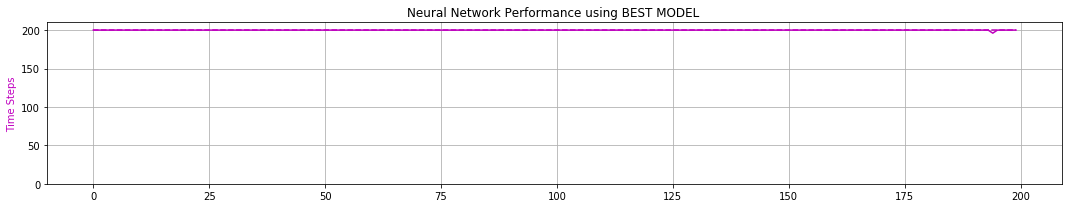

0 -max- [ 0.122  0.741  0.050  0.669  0.294]
0 -min- [-2.400 -2.182 -0.162 -1.088  0.206]

1 -max- [ 0.100  0.600  0.048  0.618  0.299]
1 -min- [-2.397 -2.068 -0.126 -0.873  0.208]

2 -max- [ 0.111  0.591  0.038  0.637  0.307]
2 -min- [-2.400 -2.212 -0.124 -0.884  0.210]

3 -max- [ 0.120  0.944  0.048  0.648  0.307]
3 -min- [-2.397 -2.068 -0.132 -1.301  0.216]

4 -max- [ 0.110  0.608  0.045  0.676  0.305]
4 -min- [-2.399 -2.055 -0.126 -0.872  0.214]

5 -max- [ 0.154  0.732  0.048  0.682  0.314]
5 -min- [-2.399 -2.065 -0.139 -1.042  0.220]

6 -max- [ 0.104  0.608  0.048  0.691  0.316]
6 -min- [-2.396 -2.068 -0.125 -0.921  0.219]

7 -max- [ 0.108  0.751  0.047  0.677  0.320]
7 -min- [-2.400 -2.038 -0.148 -1.064  0.231]

8 -max- [ 0.144  0.626  0.050  0.693  0.313]
8 -min- [-2.400 -2.059 -0.127 -0.811  0.224]

9 -max- [ 0.145  0.815  0.056  0.680  0.319]
9 -min- [-2.398 -2.058 -0.125 -1.076  0.235]

10 -max- [ 0.116  0.920  0.043  0.682  0.319]
10 -min- [-2.398 -2.045 -0.160 -1.322  0.237

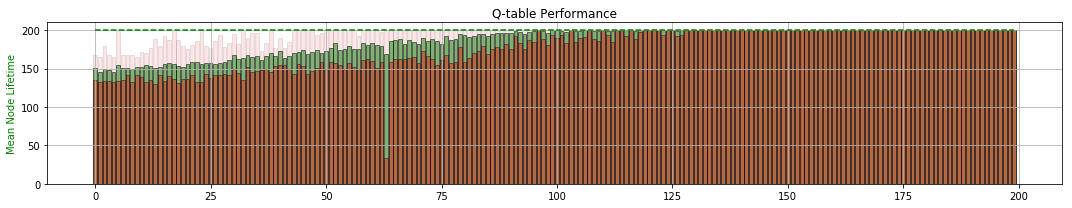

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  46541
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  197.715
Validating... MEAN TIME:  187.09
Validating... MEAN TIME:  192.27
Validating... MEAN TIME:  199.265
TRAINING TIME:0:00:49.377077


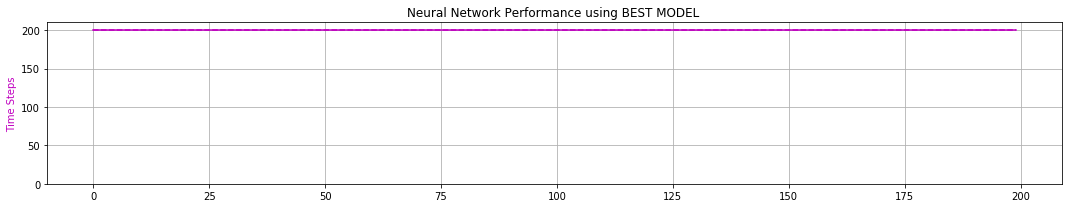

0 -max- [ 0.111  0.621  0.050  0.689  0.299]
0 -min- [-2.400 -2.024 -0.140 -0.870  0.213]

1 -max- [ 0.100  0.600  0.048  0.712  0.303]
1 -min- [-2.399 -1.883 -0.141 -1.037  0.206]

2 -max- [ 0.109  0.591  0.038  0.865  0.300]
2 -min- [-2.399 -2.041 -0.157 -0.884  0.216]

3 -max- [ 0.114  0.596  0.048  0.692  0.300]
3 -min- [-2.400 -1.882 -0.137 -0.835  0.223]

4 -max- [ 0.120  0.608  0.045  0.658  0.310]
4 -min- [-2.393 -1.884 -0.144 -0.872  0.214]

5 -max- [ 0.151  0.613  0.048  0.672  0.308]
5 -min- [-2.398 -2.026 -0.135 -0.832  0.219]

6 -max- [ 0.105  0.606  0.048  0.697  0.316]
6 -min- [-2.396 -1.988 -0.130 -0.891  0.225]

7 -max- [ 0.088  0.564  0.047  0.677  0.319]
7 -min- [-2.399 -1.999 -0.139 -0.828  0.236]

8 -max- [ 0.136  0.627  0.050  0.662  0.319]
8 -min- [-2.398 -1.884 -0.138 -0.884  0.224]

9 -max- [ 0.131  0.622  0.049  0.653  0.320]
9 -min- [-2.399 -1.880 -0.129 -0.845  0.227]

10 -max- [ 0.121  0.609  0.046  0.668  0.327]
10 -min- [-2.398 -1.993 -0.146 -0.884  0.229

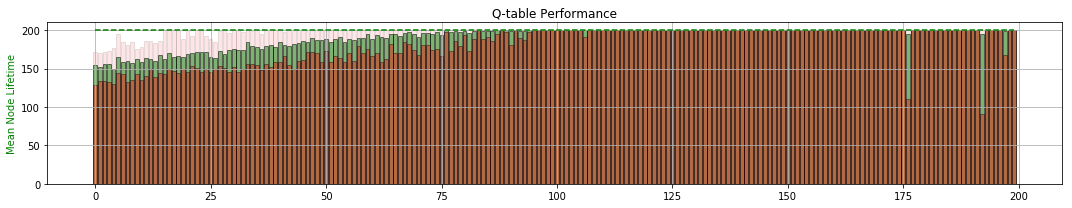

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  47816
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.995
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:51.074099


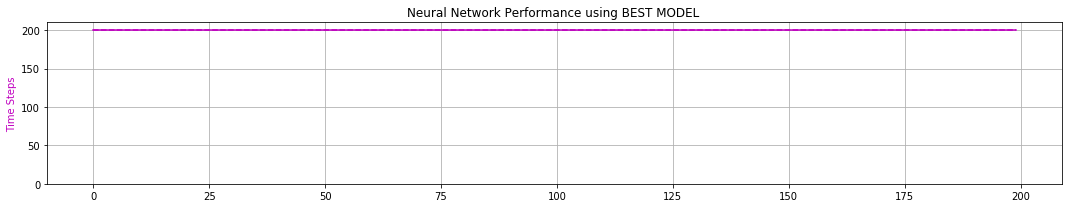

0 -max- [ 0.110  0.621  0.050  0.691  0.296]
0 -min- [-2.374 -1.818 -0.209 -0.870  0.208]

1 -max- [ 0.095  0.600  0.048  0.678  0.303]
1 -min- [-2.383 -1.843 -0.209 -0.957  0.206]

2 -max- [ 0.115  0.624  0.038  0.671  0.307]
2 -min- [-2.381 -1.877 -0.209 -0.914  0.219]

3 -max- [ 0.121  0.753  0.048  0.674  0.294]
3 -min- [-2.398 -1.865 -0.209 -1.081  0.215]

4 -max- [ 0.120  0.608  0.045  0.904  0.302]
4 -min- [-2.390 -1.856 -0.209 -0.872  0.216]

5 -max- [ 0.143  0.733  0.048  0.708  0.310]
5 -min- [-2.396 -1.863 -0.208 -1.063  0.220]

6 -max- [ 0.095  0.606  0.048  0.669  0.315]
6 -min- [-2.399 -1.993 -0.209 -0.891  0.225]

7 -max- [ 0.088  0.564  0.047  0.673  0.319]
7 -min- [-2.396 -1.824 -0.208 -0.828  0.220]

8 -max- [ 0.142  0.627  0.050  0.728  0.306]
8 -min- [-2.398 -1.820 -0.209 -1.120  0.225]

9 -max- [ 0.126  0.622  0.049  0.666  0.323]
9 -min- [-2.353 -1.858 -0.209 -0.845  0.244]

10 -max- [ 0.116  0.609  0.043  0.690  0.327]
10 -min- [-2.381 -1.880 -0.209 -0.884  0.228

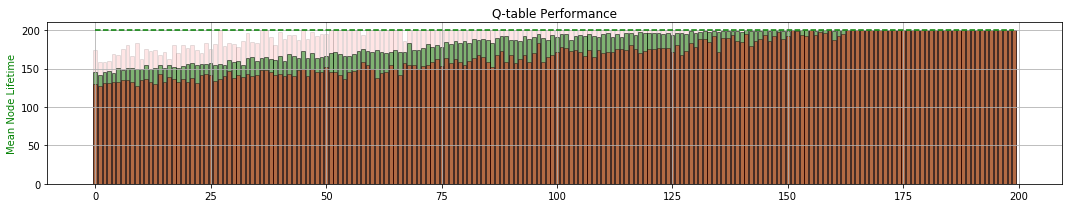

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  49944
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... 

In [ ]:
while iteration < MAX_NO_OF_ITERATIONS:
    print("\n")
    print("ITERATION #", iteration)
    print("TABULAR EPSILON = ", T_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("LARGEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.max().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        print("Problem SOLVED in iteration#", iteration)
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
    bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


    dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
    dqn.good_memory_counter += good_mem.shape[0]

    dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
    dqn.bad_memory_counter += bad_mem.shape[0]

    dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
    dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS

    print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
    print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            v_env.length   = 0.5 + np.random.uniform(-0.3,0.3)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = 0.5 + np.random.uniform(-0.3,0.3)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    for node_id in range(NO_OF_NODES):
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
        # CREATE STATE COMBINATIONS
        ###############################################

        
        ###############################################
    node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                        [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                        [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

    # SAVE QFILE
    node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
    np.save(node_QFILE, node_q_table)
        #############################################################################################################################################
    stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()
    

In [ ]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

In [ ]:
pool.close()
pool.join()